# Simple MLP demo

This notebook demonstrates how to create a simple MLP for recognizing phonemes from speech. To do this, we will use a training dataset prepared in a different notebook titled *VoxforgeDataPrep*, so take a look at that before you start working on this demo.

In this example, we will use the excellent [Keras](http://keras.io/) library which depends upon either Theano or TensorFlow, so you will need to install those as well. Just follow the isntructions on the Keras website - it is recommended to use the freshest, Github versions of both Keras and Theano.

I also have the convinence of using the GPU for the actual computation. This code will work just as well on the CPU, but it's much faster on a good GPU.

We start by importing numpy (for loading and working with the data) and the neccessary Keras classes. Feel free to add more here if you wish to experiment with them.

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD, Adadelta
from keras.callbacks import RemoteMonitor

Using Theano backend.


Using gpu device 0: GeForce GTX TITAN (CNMeM is enabled)


First let's load our data. In the *VoxforgeDataPrep* notebook, we created to arrays - inputs and outputs. The input nas the dimensions (num_samples,num_features) and the output is simply 1D vector of ints of length (num_samples). In this step, we split the training data into actual training (90%) and dev (10%) and merge that with the test data. Finally we save the indices for all the sets (instead of actual arrays).

In [2]:
import sys

sys.path.append('../python')

from data import Corpus

with Corpus('../data/mfcc_train_small.hdf5',load_normalized=True,merge_utts=True) as corp:
    train,dev=corp.split(0.9)
    
test=Corpus('../data/mfcc_test.hdf5',load_normalized=True,merge_utts=True)

tr_in,tr_out_dec=train.get()
dev_in,dev_out_dec=dev.get()
tst_in,tst_out_dec=test.get()

Next we define some constants for our program. Input and output dimensions can be inferred from the data, but the hidden layer size has to be defined manually.

We also redefine our outputs as a 1-of-N matrix instead of an int vector. The old outputs were simply a list of integers (from 0 to 39) defining the phoneme (as listed in ../data/phones.list) class for each sample given at input. The new matrix has dimensions (num_samples, num_classes) and is mostly 0 with a single 1 put in place corresponding to the class index in the old output vector.

In [6]:
input_dim=tr_in.shape[1]
output_dim=np.max(tr_out_dec)+1

hidden_num=256

batch_size=256
epoch_num=100

def dec2onehot(dec):
    num=dec.shape[0]
    ret=np.zeros((num,output_dim))
    ret[range(0,num),dec]=1
    return ret

tr_out=dec2onehot(tr_out_dec)
dev_out=dec2onehot(dev_out_dec)
tst_out=dec2onehot(tst_out_dec)

In [7]:
print 'Samples num: {}'.format(tr_in.shape[0]+dev_in.shape[0]+tst_in.shape[0])
print '   of which: {} in train, {} in dev and {} in test'.format(tr_in.shape[0],dev_in.shape[0],tst_in.shape[0])
print 'Input size: {}'.format(input_dim)
print 'Output size (number of classes): {}'.format(output_dim)

Samples num: 1595108
   of which: 1299629 in train, 138800 in dev and 156679 in test
Input size: 39
Output size (number of classes): 40


## Model definition

Here we define our model using the Keras interface. There are two main model types in Keras: sequential and graph. Sequential is much more common and easy to use, so we start with that.

Next we define the MLP topology. Here we have 3 layers: input, hidden and output. They are interconnected with two sets of *Dense* weight connections and a layer of activation functions after these weights. When defining the *Dense* weight layers, we need to provide the size: input and output are neccessary only for the first layer, subsequent layers use the output size of the previous layer as their input size.

We also define the type of optimizer and loss function we want to use. There are a few optimizers to choose from in the library and they are all interchangable. The differences between them are not too large in this example (feel free to experiment). The loss function chosen here is the cross-entropy function. Another option would be the simpler MSE (mean square error). Again, there doesn't seem to be much of a difference, but cross-entropy does seem like performing a bit better overall.

In [8]:
model = Sequential()

model.add(Dense(input_dim=input_dim,output_dim=hidden_num))
model.add(Activation('sigmoid'))
model.add(Dense(output_dim=output_dim))
model.add(Activation('softmax'))

#optimizer = SGD(lr=0.01, momentum=0.9, nesterov=True)
optimizer= Adadelta()
loss='categorical_crossentropy'

After defining the model and all its parameters, we can compile it. This literally means compiling, because the model is converted into C++ code in the background and compiled with lots of optimizations to work as efficiently as possible. The process can take a while, but is worth the added speed in training.

In [9]:
model.compile(loss=loss, optimizer=optimizer)

print model.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 39)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Dense (dense)                 (None, 256)                   10240               
Activation (activation)       (None, 256)                   0                   
Dense (dense)                 (None, 40)                    10280               
Activation (activation)       (None, 40)                    0                   
--------------------------------------------------------------------------------
Total params: 20520
--------------------------------------------------------------------------------
None


We can also try and visualize the model using the builtin Dot painter:

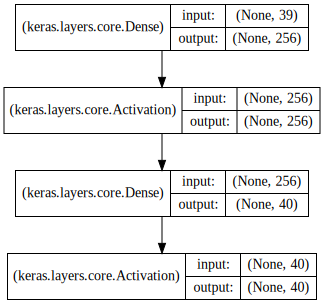

In [10]:
from keras.utils import visualize_util
from IPython.display import SVG

SVG(visualize_util.to_graph(model,show_shape=True).create(prog='dot', format='svg'))

Finally, we can start training the model. We provide the training function both training and validation data and define a few parameters: batch size and number of training epochs. Changing the batch size can affect both the training speed and final accuracy. This value is also closely related to the number of epochs. Generally, you want to run the training for as many epochs as needed for the model to converge on some value. The value of 100 should be fine for a quick comparison but up to 1k may be necessary to be abolutely sure (especially when testing larger models).

In [11]:
val=(dev_in,dev_out)

hist=model.fit(tr_in, tr_out, shuffle=True, batch_size=batch_size, nb_epoch=epoch_num, verbose=0, validation_data=val)

The training method returns an object that contains the trained model parameters and the training history:

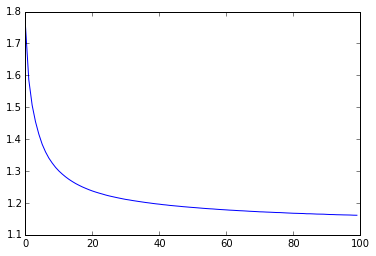

In [12]:
import matplotlib.pyplot as P
%matplotlib inline

P.plot(hist.history['loss'])

You can get better graphs and more data if you overload the training callback method, which will provide you with the model parameters after each epoch during training.

After the model is trained, we can easily test it using the evaluate method. The show_accuracy argument is required to compute the accuracy of the decision variable. The returned result has a 2-element list, where the first value is the loss of the model on the test data and the second is the accuracy:

In [13]:
res=model.evaluate(tst_in,tst_out,batch_size=batch_size,show_accuracy=True,verbose=0)

In [14]:
print 'Loss: {}'.format(res[0])
print 'Accuracy: {:%}'.format(res[1])

Loss: 1.31919198111
Accuracy: 61.396231%


One other way to look at this is to check where the errors occur by looking at what's known as the *confusion matrix*. The confusion matrix counts the number of predicted outputs with respect on how they should have been predicted. All the values on the diagonal (so where the predicted class is equal to the reference) are correct results. Any values outside of the diagonal are the errors, or confusions of one class with another. For example, you can see that 'g' is confused by 'k' (both same phonation place, but different voiceness), 'r' with 'er' (same thing, but the latter is a diphone), 't' with 'ch' (again same phonantion place, but sligthly different pronounciaction) and so on...

In [15]:
out = model.predict_classes(tst_in,batch_size=256,verbose=0)

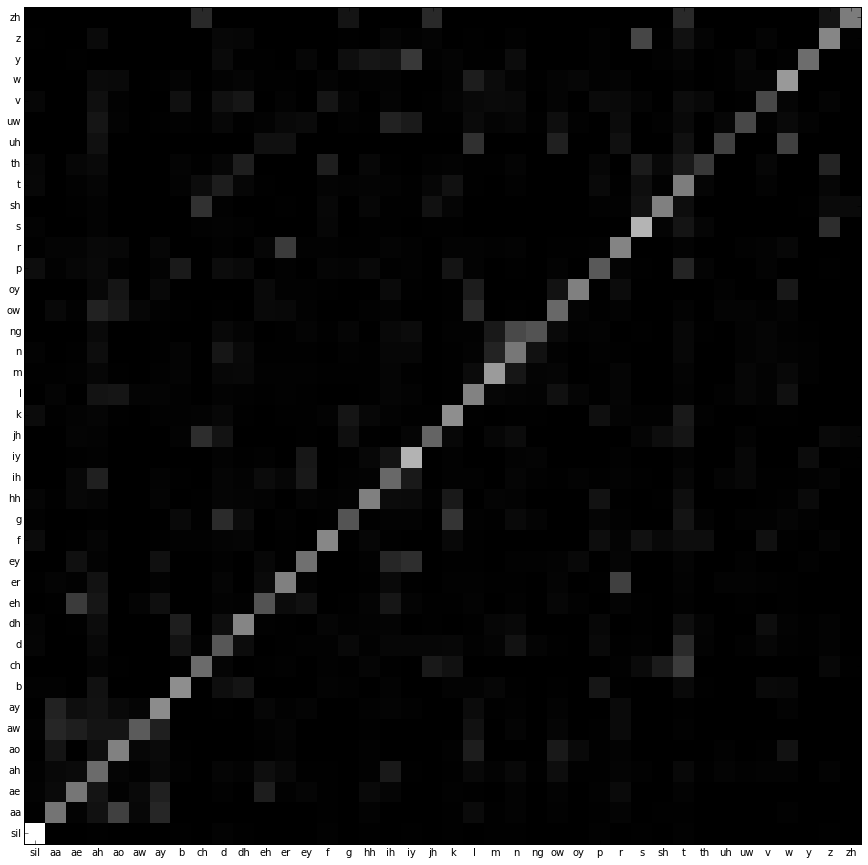

In [17]:
confusion=np.zeros((output_dim,output_dim))
for s in range(len(out)):
    confusion[out[s],tst_out_dec[s]]+=1

#normalize by class - because some classes occur much more often than others
for c in range(output_dim):
    confusion[c,:]/=np.sum(confusion[c,:])

with open('../data/phones.list') as f:
    ph=f.read().splitlines()
    
P.figure(figsize=(15,15))
P.pcolormesh(confusion,cmap=P.cm.gray)
P.xticks(np.arange(0,output_dim)+0.5)
P.yticks(np.arange(0,output_dim)+0.5)
ax=P.axes()
ax.set_xticklabels(ph)
ax.set_yticklabels(ph)
print ''

## Further steps

You can play around with the different parameters and network topologies. The results aren't going to be much better using this type of model. Using recurrent topologies (e.g. LSTM) can work better, as well as providing more data. Crucially, however, framewise phoneme classification is not the best benchmark to test and isn't the most useful. Further notebooks will go into other technuiques for getting closer to the best speech recognition can provide.